Distance matrix
[[inf, 5.0, 1.0, 2.0, 10.0, 1.0, 2.0, 9.0, 10.0, 1.0], [9.0, inf, 5.0, 4.0, 1.0, 5.0, 7.0, 9.0, 2.0, 9.0], [5.0, 2.0, inf, 7.0, 6.0, 4.0, 10.0, 7.0, 10.0, 2.0], [10.0, 5.0, 3.0, inf, 8.0, 9.0, 9.0, 10.0, 3.0, 1.0], [7.0, 8.0, 9.0, 2.0, inf, 2.0, 5.0, 1.0, 9.0, 6.0], [5.0, 8.0, 9.0, 9.0, 3.0, inf, 3.0, 9.0, 9.0, 7.0], [7.0, 6.0, 7.0, 1.0, 1.0, 7.0, inf, 2.0, 9.0, 10.0], [2.0, 3.0, 9.0, 10.0, 10.0, 6.0, 1.0, inf, 8.0, 4.0], [1.0, 5.0, 3.0, 1.0, 4.0, 4.0, 2.0, 3.0, inf, 10.0], [1.0, 2.0, 1.0, 2.0, 10.0, 1.0, 10.0, 3.0, 2.0, inf]]
Shortest Path: [(9, 2), (2, 1), (1, 8), (8, 0), (0, 5), (5, 4), (4, 7), (7, 6), (6, 3), (3, 9)]
Shortest Path Length: 14.0


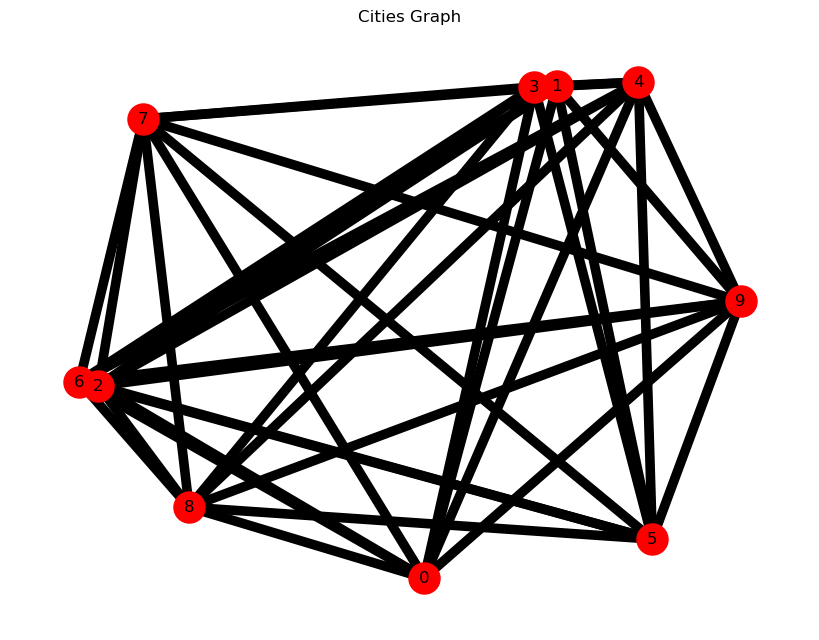

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

class AntColony:
    def __init__(self, distances, n_ants, n_best, n_iterations, initial_pheromone, evaporation, delta_pheromone_factor=1, alpha=1, beta=1):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iteration (int): Number of iterations
            evaporation (float): Rate it which pheromone evaporates. 
                                 The pheromone value is multiplied by evaporation, 
                                 so 0.95 will lead to slow decay, 0.5 to much faster decay.
            delta_pheromone_factor: pheromone amount to be normalized with distance
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
        """
        self.distances  = distances
        self.pheromone = np.ones(self.distances.shape) * initial_pheromone
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.initial_pheromone = initial_pheromone,
        self.evaporation = evaporation
        self.delta_pheromone_factor = delta_pheromone_factor
        self.alpha = alpha
        self.beta = beta
        self.hist = []

    def run(self):
        shortest_path = None
        shortest_path_length = np.inf
        for i in range(self.n_iterations):
            #generate all paths
            all_paths = self.gen_all_paths()
            #update pheromone considering evaporation
            self.pheromone = self.pheromone * (1-self.evaporation)
            #update pheromone based on realized paths
            self.spread_pheronome(all_paths, self.n_best)
            #get shortest path and path length
            shortest_path, shortest_path_length = self.get_shortest(all_paths)
            self.hist.append((self.rotate_to_start_from_zero(shortest_path), shortest_path_length)) 
            
        return shortest_path, shortest_path_length 

    def spread_pheronome(self, all_paths, n_best):
        #all_paths is made of tuples [(path1,lenght1),...]
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, length in sorted_paths[:n_best]:
            for move in path:
                # 1st option: deposited pheromone is delta_pheromone_factor/lenght_overall
                self.pheromone[move] += self.delta_pheromone_factor / length
                # 2nd option: deposited pheromone is delta_pheromone_factor/lenght_single_move
                # self.pheromone[move] += self.delta_pheromone_factor / self.distances[move]

    def gen_path_dist(self, path):
        #compute overall distance of a single path
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist
    
    def gen_all_paths(self):
        #generate random paths for all ants
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(np.random.choice(self.all_inds))
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            #choose next node based on heuristic and pheromone matrix
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            # append node to the path and the visited nodes
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started    
        return path

    def pick_move(self, pheromone, dist, visited):
        #copy the pheromone row on current node
        pheromone = np.copy(pheromone)
        #set pheromone to zero on paths leading to visited nodes
        pheromone[list(visited)] = 0
        # compute normalized transition probabilities
        row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)
        norm_row = row / row.sum()
        # select next move
        move = np.random.choice(self.all_inds, 1, p=norm_row)[0]
        return move

    def get_shortest(self, all_paths):
        #find shortest path in current run
        shortest_path = None
        shortest_path_length = np.inf
        for path, length in all_paths:
            if length < shortest_path_length:
                shortest_path_length = length
                shortest_path = path
        return shortest_path, shortest_path_length
    
    def rotate_to_start_from_zero(self, tuple_lists):
        #rotate path to start from the node number 0 and ease comparison
        for i, tup in enumerate(tuple_lists):
            if tup[0]==0:
                rotation_index = i
                break
        rotated_list = tuple_lists[rotation_index:] + tuple_lists[:rotation_index]
        return rotated_list

    
def define_random_distance_matrix(ncities,max_dist):
    distance=np.random.choice(np.arange(1,max_dist+1),int(ncities**2)).astype(float)
    distance=np.reshape(distance,(ncities,ncities))
    distance+=np.diag([np.inf]*ncities)
    return distance

def plot_pheromone_graph(pheromone):
    pheromone=np.copy(pheromone)
    pheromone=np.log(pheromone/np.max(pheromone)+0.001)
    
    G = nx.Graph()
    for i in range(len(pheromone)):
        G.add_node(i)

    for i in range(len(pheromone)):
        for j in range(i+1, len(pheromone)):
            G.add_edge(i, j, weight=pheromone[i][j])

    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))

    # Extracting edge weights
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    # Calculating edge thickness based on distance
    edge_thickness = [weight for weight in edge_weights]

    nx.draw(G, pos, with_labels=True, node_size=500, node_color='red', width=edge_thickness)
    #nx.draw_networkx_edge_labels(G, pos)
    plt.title('Cities Graph')
    plt.show()



# Example usage:
ncities=10
max_dist=10
np.random.seed(10)
distances = define_random_distance_matrix(ncities,max_dist)
print(f'Distance matrix\n{distances.tolist()}')

ant_colony = AntColony(distances=distances, 
                       n_ants=ncities, 
                       n_best=ncities, 
                       n_iterations=1000, 
                       initial_pheromone=1.,
                       evaporation=0.9,
                       delta_pheromone_factor=0.5,
                       alpha=1, 
                       beta=1)
shortest_path, length = ant_colony.run()
print(f"Shortest Path: {shortest_path}")
print(f"Shortest Path Length: {length}")


plot_pheromone_graph(ant_colony.pheromone)





Text(0, 0.5, 'path length')

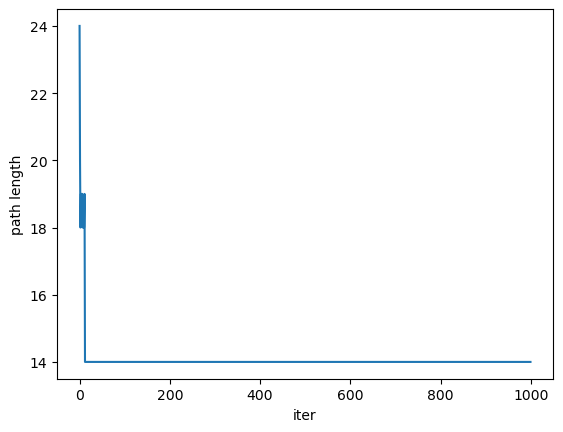

In [2]:
plt.plot([el[1] for el in ant_colony.hist])
plt.xlabel('iter')
plt.ylabel('path length')

In [3]:
for el in ant_colony.hist:
    print(el[0],el[1])

[(0, 9), (9, 1), (1, 4), (4, 7), (7, 6), (6, 3), (3, 2), (2, 5), (5, 8), (8, 0)] 24.0
[(0, 2), (2, 1), (1, 8), (8, 4), (4, 3), (3, 9), (9, 5), (5, 6), (6, 7), (7, 0)] 20.0
[(0, 2), (2, 1), (1, 4), (4, 7), (7, 9), (9, 5), (5, 6), (6, 3), (3, 8), (8, 0)] 18.0
[(0, 2), (2, 1), (1, 4), (4, 7), (7, 6), (6, 3), (3, 9), (9, 5), (5, 8), (8, 0)] 19.0
[(0, 2), (2, 1), (1, 4), (4, 7), (7, 6), (6, 3), (3, 9), (9, 5), (5, 8), (8, 0)] 19.0
[(0, 2), (2, 1), (1, 4), (4, 7), (7, 6), (6, 3), (3, 9), (9, 5), (5, 8), (8, 0)] 19.0
[(0, 2), (2, 9), (9, 5), (5, 6), (6, 7), (7, 1), (1, 4), (4, 3), (3, 8), (8, 0)] 19.0
[(0, 2), (2, 1), (1, 4), (4, 7), (7, 9), (9, 5), (5, 6), (6, 3), (3, 8), (8, 0)] 18.0
[(0, 2), (2, 1), (1, 4), (4, 7), (7, 9), (9, 5), (5, 6), (6, 3), (3, 8), (8, 0)] 18.0
[(0, 2), (2, 1), (1, 4), (4, 7), (7, 9), (9, 5), (5, 6), (6, 3), (3, 8), (8, 0)] 18.0
[(0, 2), (2, 1), (1, 4), (4, 7), (7, 9), (9, 5), (5, 6), (6, 3), (3, 8), (8, 0)] 18.0
[(0, 2), (2, 1), (1, 4), (4, 7), (7, 6), (6, 3), (3, 9

Optimal Paths:
[(0, 7), (7, 2), (2, 4), (4, 6), (6, 5), (5, 1), (1, 8), (8, 9), (9, 3), (3, 0)]
[(0, 8), (8, 9), (9, 1), (1, 2), (2, 4), (4, 7), (7, 6), (6, 5), (5, 3), (3, 0)]
[(0, 8), (8, 9), (9, 1), (1, 2), (2, 4), (4, 7), (7, 6), (6, 5), (5, 3), (3, 0)]
[(0, 8), (8, 4), (4, 9), (9, 1), (1, 5), (5, 6), (6, 2), (2, 3), (3, 7), (7, 0)]
[(0, 8), (8, 4), (4, 7), (7, 6), (6, 5), (5, 1), (1, 2), (2, 9), (9, 3), (3, 0)]
[(0, 1), (1, 8), (8, 5), (5, 6), (6, 2), (2, 4), (4, 9), (9, 3), (3, 7), (7, 0)]
[(0, 8), (8, 5), (5, 1), (1, 2), (2, 4), (4, 9), (9, 7), (7, 6), (6, 3), (3, 0)]
[(0, 6), (6, 2), (2, 4), (4, 9), (9, 1), (1, 8), (8, 5), (5, 3), (3, 7), (7, 0)]
[(0, 8), (8, 9), (9, 3), (3, 7), (7, 2), (2, 4), (4, 6), (6, 5), (5, 1), (1, 0)]
[(0, 8), (8, 5), (5, 3), (3, 7), (7, 6), (6, 2), (2, 4), (4, 9), (9, 1), (1, 0)]
[(0, 6), (6, 5), (5, 8), (8, 4), (4, 9), (9, 1), (1, 2), (2, 3), (3, 7), (7, 0)]
[(0, 8), (8, 4), (4, 9), (9, 7), (7, 6), (6, 5), (5, 3), (3, 2), (2, 1), (1, 0)]
[(0, 8), (8, 

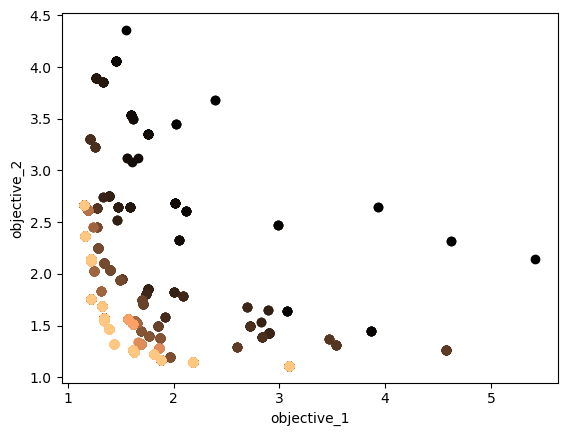

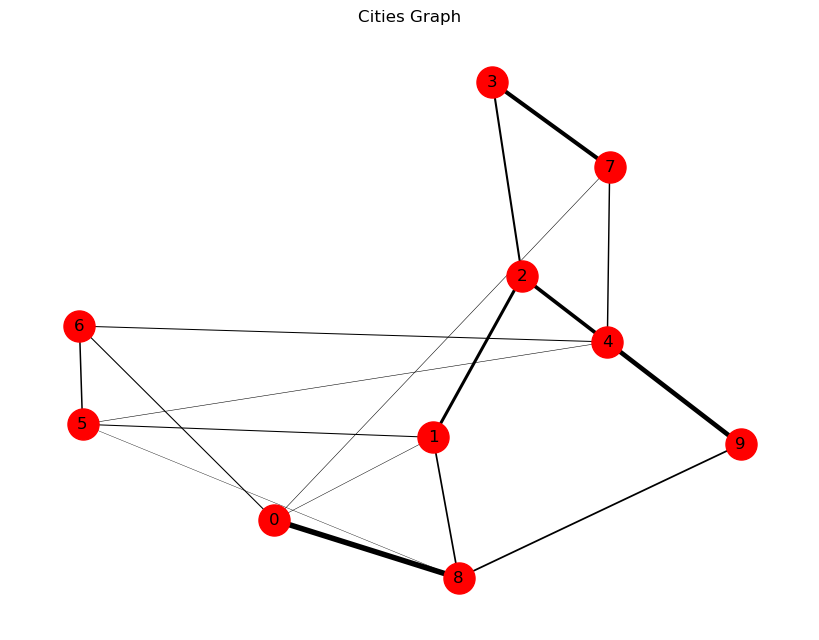

In [4]:
import numpy as np
import networkx as nx


class AntColony_MACS:
    def __init__(self, 
                 objectives, 
                 n_ants, 
                 n_iterations, 
                 initial_pheromone,
                 evaporation, 
                 delta_pheromone_factor=1, 
                 alpha=1, 
                 beta=1):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iteration (int): Number of iterations
            evaporation (float): Rate it which pheromone evaporates. 
                                 The pheromone value is multiplied by evaporation, 
                                 so 0.95 will lead to slow decay, 0.5 to much faster decay.
            delta_pheromone_factor: pheromone amount to be normalized with distance
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
        """
        self.objectives  = objectives
        self.num_objectives = len(objectives)
        self.pheromone = np.ones(self.objectives[0].shape)*initial_pheromone
        self.all_inds = range(len(self.objectives[0]))
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.evaporation = evaporation
        self.delta_pheromone_factor = delta_pheromone_factor
        self.alpha = alpha
        self.beta = beta
        self.hist = []
        self.pheromone_factor=0
        self.optimal_paths = []
        

    def run(self):
        for i in range(self.n_iterations):
            # generate all paths
            all_paths = self.gen_all_paths()
            # update pheromone based on evaporation
            self.pheromone = self.pheromone * (1-self.evaporation)
            ## select pareto optimal and drop others
            self.optimal_paths, new_pheromone_factor = self.get_optimal_and_factor(all_paths)
            
            #if new_pheromone_factor>self.pheromone_factor reinitialize the pheromone matrix accordingly
            if new_pheromone_factor>self.pheromone_factor:
                self.pheromone_factor=new_pheromone_factor
                self.pheromone = np.ones(self.objectives[0].shape)*self.pheromone_factor*self.delta_pheromone_factor                     
            else:
                ## update pheromone using only non-dominated solutions
                self.spread_pheronome(self.optimal_paths)
            #append to history all optimal paths
            self.hist.append([(self.rotate_to_start_from_zero(el[0]), el[1]) for el in self.optimal_paths])            
        return self.hist, new_pheromone_factor 

    def spread_pheronome(self, optimal_paths):
        # spread pheromone according to the aggregated utility of all optimal paths
        #all_paths is made of tuples [(path1,lenght1),...]
        for path, objectives in optimal_paths:
            delta_pheromone_path=np.prod(objectives)
            
            for move in path:
                self.pheromone[move] += self.evaporation * self.delta_pheromone_factor * delta_pheromone_path

    def gen_path_objectives(self, path):
        # collect objective vector o a single path
        obj_values=[]
        for obj_ind in range(self.num_objectives): 
            total_obj = 0
            for ele in path:
                total_obj += self.objectives[obj_ind][ele]
            obj_values.append(total_obj)
        return obj_values
    
    def gen_all_paths(self):
        #generate all random paths
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(np.random.choice(self.all_inds))
            all_paths.append((path, self.gen_path_objectives(path)))
        return all_paths

    def gen_path(self, start):
        ## generate random normalized weights
        ant_weights = self.generate_random_normalized_weights()
        ## aggregate heuristic matrices using ant weights
        weighted_eta = self.aggregate_heuristic_matrices(ant_weights)
        
        path = []
        visited = set()
        visited.add(start)
        prev = start
        ## compute next moves based on transition probability
        for i in range(len(self.objectives[0]) - 1): 
            move = self.pick_move(self.pheromone[prev], weighted_eta[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started    
        return path
    
    def generate_random_normalized_weights(self):
        # Generate N - 1 random numbers between 0 and 1
        random_numbers = np.random.rand(self.num_objectives - 1)
        # Sort the random numbers in ascending order
        random_numbers.sort()
        # Calculate differences between consecutive numbers
        differences = np.diff(random_numbers)
        # Concatenate 0 at the beginning and 1 at the end
        random_array = np.concatenate(([random_numbers[0]], differences, [1 - random_numbers[-1]]))
        return random_array
    
    def aggregate_heuristic_matrices(self,weights):
        ## aggregate heuristic matrix using MACS prescription
        weighted_objective=[objective**weight for objective,weight in zip(self.objectives,weights)]
        weigthed_eta = np.stack(weighted_objective).prod(0)
        return weigthed_eta


    def pick_move(self, pheromone, heuristic, visited):
        #copy the phermone matrix row
        pheromone = np.copy(pheromone)
        #set transition probability to already visited nodes to zero
        pheromone[list(visited)] = 0
        #compute transition probability 
        row = (pheromone ** self.alpha) * (heuristic ** self.beta)
        norm_row = row / row.sum()
        #roulette selection
        move = np.random.choice(self.all_inds, 1, p=norm_row)[0]
        return move

    def get_optimal_and_factor(self, all_paths):
        #join old optimal paths with new paths
        paths_list = self.optimal_paths + all_paths 
        # list all objective values
        objective_list=[]
        for path, objectives in paths_list:
            objective_list.append(objectives)
        
        # identify non dominated solutions
        non_dominated_indices = self.ParetoFront(objective_list)
        
        # store optimal paths and remove duplicates
        optimal_paths = [paths_list[opt] for opt in non_dominated_indices]
        optimal_paths = self.remove_optimal_duplicates(optimal_paths)
        
        # compute new pheromone factor based on optimal solutions
        new_pheromone_factor = [el[1] for el in optimal_paths]
        new_pheromone_factor = self.delta_pheromone_factor * np.array(new_pheromone_factor).mean(0).prod()
        
        return optimal_paths, new_pheromone_factor
    
    def remove_optimal_duplicates(self,optimal_paths):
        seen = set()
        result = []
        for item in optimal_paths:
            # Convert the first element (list of tuples) to a frozenset for hashing
            key = (frozenset(item[0]), tuple(item[1]))
            if key not in seen:
                result.append(item)
                seen.add(key)
        return result
    
    
    def ParetoFront(self,list_fs):
        def dominates(f1,f2):
            f1=np.array(f1)
            f2=np.array(f2)
            return np.all(f1<=f2) and np.any(f1<f2)
        list_fs=np.array(list_fs)
        pareto_front = list()
        point_is_dominated_by={}

        for idi, _ in enumerate(list_fs):
            point_is_dominated_by[idi] = list()

        for id1, obj1 in enumerate(list_fs): ## upper triangular matrix
            for index2, obj2 in enumerate(list_fs[id1 + 1:]):  # Avoid redundant comparisons
                id2 = index2 + id1 + 1
                if dominates(obj1,obj2):
                    point_is_dominated_by[id2].append(id1)
                elif dominates(obj2,obj1):
                    point_is_dominated_by[id1].append(id2)

            if not point_is_dominated_by[id1]:
                pareto_front.append(id1)

        return pareto_front 

    
    def rotate_to_start_from_zero(self, tuple_lists):
        for i, tup in enumerate(tuple_lists):
            if tup[0]==0:
                rotation_index = i
                break
        rotated_list = tuple_lists[rotation_index:] + tuple_lists[:rotation_index]
        return rotated_list
    
   
    
def define_random_distance_matrix(ncities,max_dist):
    distance=np.random.choice(np.arange(1,max_dist+1),int(ncities**2)).astype(float)
    distance=np.reshape(distance,(ncities,ncities))
    distance+=np.diag([np.inf]*ncities)
    return distance

def generate_color_palette(N, cmap_name):
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(x) for x in np.linspace(0, 1, N)]
    return colors

def plot_pheromone_graph(pheromone):
    pheromone=np.copy(pheromone)
    pheromone=pheromone/np.max(pheromone)
    
    G = nx.Graph()
    for i in range(len(pheromone)):
        G.add_node(i)

    for i in range(len(pheromone)):
        for j in range(i+1, len(pheromone)):
            G.add_edge(i, j, weight=pheromone[i][j])

    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))

    # Extracting edge weights
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    # Calculating edge thickness based on distance
    edge_thickness = [4* weight for weight in edge_weights]

    nx.draw(G, pos, with_labels=True, node_size=500, node_color='red', width=edge_thickness)
    #nx.draw_networkx_edge_labels(G, pos)
    plt.title('Cities Graph')
    plt.show()



# Example usage:
ncities=10
max_dist=10
np.random.seed(7)
objectives=[1/define_random_distance_matrix(ncities,max_dist) for i in range(2)]
initial_pheromone=np.prod(np.stack(objectives).sum(1).sum(1)/(len(objectives[0])*(len(objectives[0])-1)))

ant_colony = AntColony_MACS(objectives=objectives, 
                       n_ants=ncities,  
                       n_iterations=300,
                       initial_pheromone=initial_pheromone,
                       evaporation=0.1,
                       delta_pheromone_factor=1,
                       alpha=1, 
                       beta=1)
hist, last_pheromone_update = ant_colony.run()



color_list=generate_color_palette(len(hist), 'copper')


print(f"Optimal Paths:")
for el in hist[-1]:
    print(el[0])
#print(f"Objectives: {[el[1] for el in optimal_paths]}")
for i, optimal_set in enumerate(hist):
    plt.scatter([el[1][0] for el in optimal_set],[el[1][1] for el in optimal_set],color=color_list[i])
plt.xlabel('objective_1')
plt.ylabel('objective_2')
plt.show()

plot_pheromone_graph(ant_colony.pheromone)




# Performance indicators

Approximate ideal point [1.15396825 1.06507937]
Approximate nadir point [5.225 5.425]


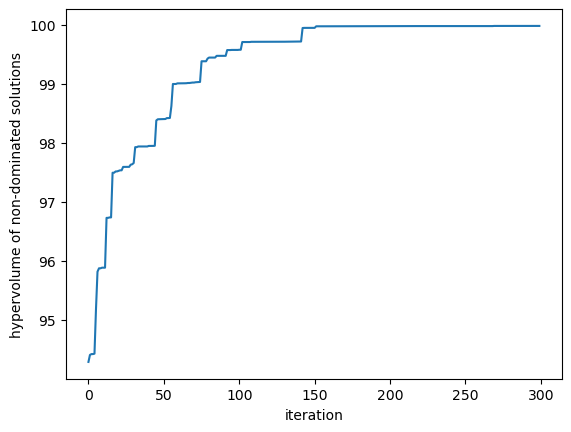

In [8]:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

#approximate ideal and nadir points using all stored optimal solutions
all_non_dominated_fronts=[np.array([el[1] for el in hist[i]]) for i in range(len(hist))]

approx_ideal = np.concatenate(all_non_dominated_fronts).min(axis=0)
approx_nadir = np.concatenate(all_non_dominated_fronts).max(axis=0)
print(f'Approximate ideal point {approx_ideal}')
print(f'Approximate nadir point {approx_nadir}')



### define hypervolume metric
from pymoo.indicators.hv import Hypervolume

metric = Hypervolume(ref_point= np.array([10., 10.]), ## worst possible case
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

## compute evolution of HV of non-dominated solutions in time:
hvs=[]
for i in range(len(hist)):
    non_dominated_front_iter_i=np.array([el[1] for el in hist[i]])
    hv=metric.do(non_dominated_front_iter_i)
    hvs.append(hv)                                  

#plot the hv evolution
plt.plot(range(len(hist)),hvs)
plt.xlabel('iteration')
plt.ylabel('hypervolume of non-dominated solutions')
plt.show()

Run nr. 1
Run nr. 2
Run nr. 3
Run nr. 4
Run nr. 5
Run nr. 6
Run nr. 7
Run nr. 8
Run nr. 9
Run nr. 10
all non-dominated solutions together are 205
really non-dominated ones are 29
unique non-dominated solutions are 29


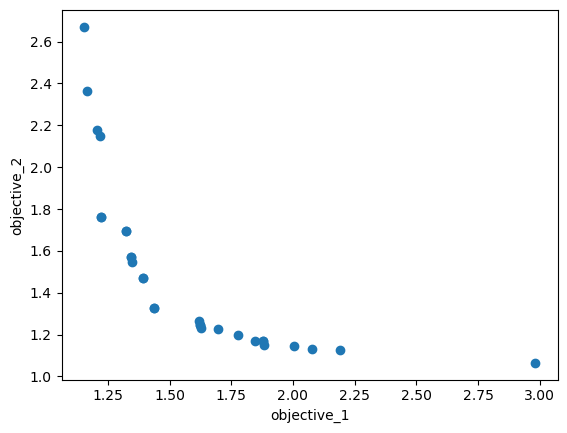

In [9]:
## Approximate the true pareto front using multiple runs

n_runs=10

ncities=10
max_dist=10
np.random.seed(7)
objectives=[1/define_random_distance_matrix(ncities,max_dist) for i in range(2)]
initial_pheromone=np.prod(np.stack(objectives).sum(1).sum(1)/(len(objectives[0])*(len(objectives[0])-1)))

    

keep_optimal=[]
for run in range(n_runs):
    print(f'Run nr. {run+1}')
    # Example usage:
   
    ant_colony = AntColony_MACS(objectives=objectives, 
                           n_ants=ncities,  
                           n_iterations=300,
                           initial_pheromone=initial_pheromone,
                           evaporation=0.1,
                           delta_pheromone_factor=1,
                           alpha=1, 
                           beta=1)
    hist, last_pheromone_update = ant_colony.run()
    
    keep_optimal += hist[-1]

print(f'all non-dominated solutions together are {len(keep_optimal)}')
keep_optimal, _ = ant_colony.get_optimal_and_factor(keep_optimal)

print(f'really non-dominated ones are {len(keep_optimal)}')
keep_optimal = ant_colony.remove_optimal_duplicates(keep_optimal)
print(f'unique non-dominated solutions are {len(keep_optimal)}')

plt.scatter([el[1][0] for el in keep_optimal],[el[1][1] for el in keep_optimal])
plt.xlabel('objective_1')
plt.ylabel('objective_2')
plt.show()

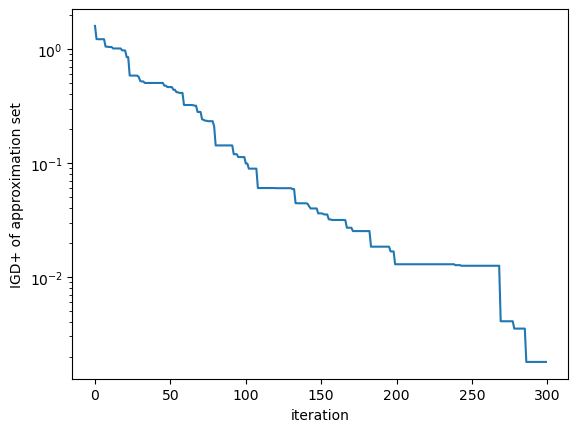

In [10]:
from pymoo.indicators.igd_plus import IGDPlus


pf=np.array([el[1] for el in keep_optimal])
metric = IGDPlus(pf, zero_to_one=True)

## compute evolution of HV of non-dominated solutions in time:
igds=[]
for i in range(len(hist)):
    non_dominated_front_iter_i=np.array([el[1] for el in hist[i]])
    igd=metric.do(non_dominated_front_iter_i)
    igds.append(igd)                                  

#plot the hv evolution
plt.plot(range(len(hist)),igds)
plt.xlabel('iteration')
plt.ylabel('IGD+ of approximation set')
plt.yscale('log')
plt.show()